# HW5

### practice Support Vector Machine

- training
    - `X_train.csv`
        - image
        - 5000 * 784(28 * 28)
    - `T_train.csv`
        - label
        - 5000 * 1
- testing
    - `X_test.csv`
        - image
        - 2500 * 784(28 * 28)
    - `T_test.csv`
        - label
        - 2500 * 1

In [179]:
import numpy as np
from matplotlib import pyplot as plt
import libsvm.python.svm as svm
import libsvm.python.svmutil as svmutil
import scipy
import ctypes
import pandas as pd

In [367]:
import time

start_tic_time = 0
def tic():
    global start_tic_time
    start_tic_time = time.time()
    return start_tic_time

def toc():
    global start_tic_time
    elapsed_time = time.time() - start_tic_time
    return elapsed_time

In [2]:
X_train = np.genfromtxt('X_train.csv', delimiter=',')
T_train = np.genfromtxt('T_train.csv', delimiter=',')
X_test = np.genfromtxt('X_test.csv', delimiter=',')
T_test = np.genfromtxt('T_test.csv', delimiter=',')

#### prepare data fit libsvm format

- in csv

```
label index:value index:value ...
label index:value index:value ...
```

- in python struct

```python
label = [1,2]
data = [{1:2,3:1},{3:2,10:1}]
```

In [459]:
def sparse_matrix(x, iskernel=False):
    row = x.shape[0]
    col = x.shape[1]
    idx_offset = 1
    if (iskernel):
        x = np.append(np.linspace(1,row,row), x).reshape(col+1,row).T
        idx_offset = 0
    x = [{idx+idx_offset:x[i][idx] \
        for _,idx in np.ndenumerate(np.argwhere(x[i]!=0))} \
        for i in range(x.shape[0])]
    return x

In [287]:
%%time
x_train = sparse_matrix(X_train)
y_train = list(T_train)
#x_train = [{idx+1:X_train[i][idx] for _,idx in np.ndenumerate(np.argwhere(X_train[i]!=0))} for i in range(X_train.shape[0])]

x_test = sparse_matrix(X_test)
y_test = list(T_test)
#x_test = [{idx+1:X_test[i][idx] for _,idx in np.ndenumerate(np.argwhere(X_test[i]!=0))} for i in range(X_test.shape[0])]

CPU times: user 2.05 s, sys: 24 ms, total: 2.07 s
Wall time: 2.07 s


### different kernel functions

- linear

$ K(u,v) = u^Tv$

- polynomial

$ K(u,v,c,d) = (u^Tv + c)^d$

- RBF

$ K(u,v,\gamma) = exp({-\gamma |u - v|^2}) $

#### libsvm option

```
options:
-s svm_type : set type of SVM (default 0)
	0 -- C-SVC
	1 -- nu-SVC
	2 -- one-class SVM
	3 -- epsilon-SVR
	4 -- nu-SVR
-t kernel_type : set type of kernel function (default 2)
	0 -- linear: u'*v
	1 -- polynomial: (gamma*u'*v + coef0)^degree
	2 -- radial basis function: exp(-gamma*|u-v|^2)
	3 -- sigmoid: tanh(gamma*u'*v + coef0)
-d degree : set degree in kernel function (default 3)
-g gamma : set gamma in kernel function (default 1/num_features)
-r coef0 : set coef0 in kernel function (default 0)
-c cost : set the parameter C of C-SVC, epsilon-SVR, and nu-SVR (default 1)
-n nu : set the parameter nu of nu-SVC, one-class SVM, and nu-SVR (default 0.5)
-p epsilon : set the epsilon in loss function of epsilon-SVR (default 0.1)
-m cachesize : set cache memory size in MB (default 100)
-e epsilon : set tolerance of termination criterion (default 0.001)
-h shrinking: whether to use the shrinking heuristics, 0 or 1 (default 1)
-b probability_estimates: whether to train a SVC or SVR model for probability estimates, 0 or 1 (default 0)
-wi weight: set the parameter C of class i to weight*C, for C-SVC (default 1)
```

[LIBSVM学习（六）代码结构及c-SVC过程](https://blog.csdn.net/u014772862/article/details/51835192)

In [72]:
m = {}
p_label = {}
p_acc = {}
p_val = {}

In [86]:
parastrs = {
    'linear' : '-t 0',
    'polynomial d=3 c=0' : '-t 1 -d 3 -r 0',
    'polynomial d=3 c=1' : '-t 1 -d 3 -r 1',
    'polynomial d=10 c=0' : '-t 1 -d 10 -r 0',
    'polynomial d=10 c=1' : '-t 1 -d 10 -r 1',
    'RBF g=0.0013' : '-t 2 -g 0.0013',
    'RBF g=0.0033' : '-t 2 -g 0.0033',
    'RBF g=0.5' : '-t 2 -g 0.5',
    'RBF g=1' : '-t 2 -g 1',
}

In [87]:
%%time

for kernel_type, opts in parastrs.items():
    if not (kernel_type in m):
        m[kernel_type] = svmutil.svm_train(y_train, x_train, opts)
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test, m[kernel_type])
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))

Accuracy = 95.08% (2377/2500) (classification)
kernel type : linear , acc : (95.08, 0.1404, 0.931149802516624)

Accuracy = 34.68% (867/2500) (classification)
kernel type : polynomial d=3 c=0 , acc : (34.68, 2.6212, 0.14887572191533946)

Accuracy = 95.76% (2394/2500) (classification)
kernel type : polynomial d=3 c=1 , acc : (95.76, 0.1356, 0.9336123460070571)

Accuracy = 20.72% (518/2500) (classification)
kernel type : polynomial d=10 c=0 , acc : (20.72, 2.9884, 0.007062945744989033)

Accuracy = 97.32% (2432/2500) (classification)
kernel type : polynomial d=10 c=1 , acc : (97.32, 0.0924, 0.954375041275707)

Accuracy = 95.32% (2383/2500) (classification)
kernel type : RBF g=0.0013 , acc : (95.32000000000001, 0.1492, 0.9271864783823697)

Accuracy = 96.36% (2409/2500) (classification)
kernel type : RBF g=0.0033 , acc : (96.36, 0.1188, 0.9415603861168684)

Accuracy = 43% (1075/2500) (classification)
kernel type : RBF g=0.5 , acc : (43.0, 1.5768, 0.219471432111856)

Accuracy = 30.04% (751/25

In [205]:
#help(svmutil.svm_train)

In [288]:
#help(svmutil.svm_problem)
prob = svmutil.svm_problem(y_train, x_train)

### use C-SVC

use grid search and cross-validation

```
-v n: n-fold cross validation mode
```

In [485]:
def GridSearchForSVM(kernel, parameter_matrix, problem, n_ford=10):
    opts = list(parameter_matrix.keys())
    opts_max = np.array([len(parameter_matrix[opts[i]]) \
                         for i in range(len(opts))])
    current_opt = np.array([0 for i in range(len(opts))])
    results = [];
    
    optstr_init = '-t {:d} -v {:d} '.format(int(kernel),int(n_ford))
    
    overflow = False
    while(True):
        while (np.count_nonzero(current_opt >= opts_max)):
            reset_indicator = np.argwhere(current_opt >= opts_max)
            current_opt[reset_indicator[-1]] -= opts_max[reset_indicator[-1]] 
            if (reset_indicator[-1]-1 < 0):
                overflow = True
                break;
            current_opt[reset_indicator[-1]-1] += 1
        
        if (overflow):
            break
        
        # gen option string
        optstr = optstr_init
        result = []
        for idx,para in enumerate(current_opt):
            optkey = opts[idx]
            optstr += '-' + str(optkey) + ' ' \
            + str(parameter_matrix[optkey][para]) + ' '
            result.append(parameter_matrix[optkey][para])
        
        # get cross-validation result
        result.append(optstr)
        result.append(svmutil.svm_train(problem, optstr))
        
        results.append(result)
        # try next options
        current_opt[-1] += 1
    
    opts += ['opt str', 'result']
    return results, opts

In [344]:
%%time
linear_results, linear_options = GridSearchForSVM(0, {'c' : [10**-5,10**-2,1,10**2,10**5]}, prob)

Cross Validation Accuracy = 79.32%
Cross Validation Accuracy = 97.06%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 96.32%
Cross Validation Accuracy = 96.28%
CPU times: user 7min 11s, sys: 87.7 ms, total: 7min 11s
Wall time: 7min 11s


In [345]:
linear_table = pd.DataFrame(linear_results, columns=linear_options)

linear_table.to_csv('linear_results.csv')

display(linear_table.sort_values(by=['result'], ascending=False))

,c,opt str,result
1,0.01000,-t 0 -v 10 -c 0.01,97.06
3,100.00000,-t 0 -v 10 -c 100,96.32
4,100000.00000,-t 0 -v 10 -c 100000,96.28
2,1.00000,-t 0 -v 10 -c 1,96.24
0,0.00001,-t 0 -v 10 -c 1e-05,79.32


In [346]:
#pd.read_csv('linear_results.csv', index_col=0)

In [398]:
%%time
poly_results, poly_options = GridSearchForSVM(1, {'c' : [10**-2,1,10**2],'g' : [1/100,1/300,1/784], 'r' : [0,1],'d' : [2,3,4,10]}, prob)

Cross Validation Accuracy = 81.78%
Cross Validation Accuracy = 65.72%
Cross Validation Accuracy = 51.68%
Cross Validation Accuracy = 33.48%
Cross Validation Accuracy = 93.68%
Cross Validation Accuracy = 94.88%
Cross Validation Accuracy = 96.1%
Cross Validation Accuracy = 97.6%
Cross Validation Accuracy = 45.14%
Cross Validation Accuracy = 28.14%
Cross Validation Accuracy = 23.44%
Cross Validation Accuracy = 20.5%
Cross Validation Accuracy = 87.98%
Cross Validation Accuracy = 90.78%
Cross Validation Accuracy = 92.34%
Cross Validation Accuracy = 95.82%
Cross Validation Accuracy = 45.32%
Cross Validation Accuracy = 28.02%
Cross Validation Accuracy = 23.48%
Cross Validation Accuracy = 20.5%
Cross Validation Accuracy = 78.26%
Cross Validation Accuracy = 80.98%
Cross Validation Accuracy = 85.6%
Cross Validation Accuracy = 92.44%
Cross Validation Accuracy = 97.58%
Cross Validation Accuracy = 96.68%
Cross Validation Accuracy = 93.46%
Cross Validation Accuracy = 60.9%
Cross Validation Accuracy 

In [403]:
poly_table = pd.DataFrame(poly_results, columns=poly_options)

poly_table.to_csv('poly_results.csv')

display(poly_table.sort_values(by=['result'], ascending=False))

,c,g,r,d,opt str,result
56,100.00,0.003333,0,2,-t 1 -v 10 -c 100 -g 0.0033333333333333335 -r ...,98.20
39,1.00,0.003333,1,10,-t 1 -v 10 -c 1 -g 0.0033333333333333335 -r 1 ...,98.14
48,100.00,0.010000,0,2,-t 1 -v 10 -c 100 -g 0.01 -r 0 -d 2,98.14
53,100.00,0.010000,1,3,-t 1 -v 10 -c 100 -g 0.01 -r 1 -d 3,98.14
29,1.00,0.010000,1,3,-t 1 -v 10 -c 1 -g 0.01 -r 1 -d 3,98.08
30,1.00,0.010000,1,4,-t 1 -v 10 -c 1 -g 0.01 -r 1 -d 4,98.04
55,100.00,0.010000,1,10,-t 1 -v 10 -c 100 -g 0.01 -r 1 -d 10,97.98
54,100.00,0.010000,1,4,-t 1 -v 10 -c 100 -g 0.01 -r 1 -d 4,97.98
63,100.00,0.003333,1,10,-t 1 -v 10 -c 100 -g 0.0033333333333333335 -r ...,97.98
71,100.00,0.001276,1,10,-t 1 -v 10 -c 100 -g 0.0012755102040816326 -r ...,97.92


In [414]:
poly_table['opt str'][39]

'-t 1 -v 10 -c 1 -g 0.0033333333333333335 -r 1 -d 10 '

In [401]:
%%time
rbf_results, rbf_options = GridSearchForSVM(2, {'c' : [10**-5,10**-2,1,10**2,10**5],'g' : [1,1/50,1/100,1/300,1/784]}, prob)

Cross Validation Accuracy = 20.56%
Cross Validation Accuracy = 93.06%
Cross Validation Accuracy = 89.92%
Cross Validation Accuracy = 83.98%
Cross Validation Accuracy = 81.22%
Cross Validation Accuracy = 20.5%
Cross Validation Accuracy = 93.6%
Cross Validation Accuracy = 92.68%
Cross Validation Accuracy = 87.02%
Cross Validation Accuracy = 81.22%
Cross Validation Accuracy = 30.22%
Cross Validation Accuracy = 98.4%
Cross Validation Accuracy = 98%
Cross Validation Accuracy = 97.28%
Cross Validation Accuracy = 96.4%
Cross Validation Accuracy = 31.16%
Cross Validation Accuracy = 98.58%
Cross Validation Accuracy = 98.4%
Cross Validation Accuracy = 97.74%
Cross Validation Accuracy = 97.26%
Cross Validation Accuracy = 31.94%
Cross Validation Accuracy = 98.64%
Cross Validation Accuracy = 98.46%
Cross Validation Accuracy = 97.7%
Cross Validation Accuracy = 97.48%
CPU times: user 1h 23min 52s, sys: 4.93 s, total: 1h 23min 57s
Wall time: 1h 24min


In [402]:
rbf_table = pd.DataFrame(rbf_results, columns=rbf_options)

rbf_table.to_csv('rbf_results.csv')

display(rbf_table.sort_values(by=['result'], ascending=False))

,c,g,opt str,result
21,100000.00000,0.020000,-t 2 -v 10 -c 100000 -g 0.02,98.64
16,100.00000,0.020000,-t 2 -v 10 -c 100 -g 0.02,98.58
22,100000.00000,0.010000,-t 2 -v 10 -c 100000 -g 0.01,98.46
11,1.00000,0.020000,-t 2 -v 10 -c 1 -g 0.02,98.40
17,100.00000,0.010000,-t 2 -v 10 -c 100 -g 0.01,98.40
12,1.00000,0.010000,-t 2 -v 10 -c 1 -g 0.01,98.00
18,100.00000,0.003333,-t 2 -v 10 -c 100 -g 0.0033333333333333335,97.74
23,100000.00000,0.003333,-t 2 -v 10 -c 100000 -g 0.0033333333333333335,97.70
24,100000.00000,0.001276,-t 2 -v 10 -c 100000 -g 0.0012755102040816326,97.48
13,1.00000,0.003333,-t 2 -v 10 -c 1 -g 0.0033333333333333335,97.28


### linear + RBF kernel

use precomputed data

```
New training instance for xi:

<label> 0:i 1:K(xi,x1) ... L:K(xi,xL)
```

- problem option
```
iskernel = True
```
- train option
```
    -t 4 precomputed kernel
```

In [473]:
def dot_square(x):
    return np.dot(x, x)

def linear_RBF_kernel(u, v, gamma=0.01):
    design_x = np.matmul(u, v.T)
    rbf_design_x = [[dot_square(u_i-v_i)*(-gamma) for v_i in v] for u_i in u]
    rbf_design_x = np.exp(rbf_design_x)
    #design_x = design_x + rbf_design_x
    design_x = rbf_design_x
    return design_x

def linear_RBF_kernel_2(u, v, gamma=0.01):
    design_x = np.matmul(u, v.T)
    rbf_design_x = np.sum(u**2, axis=1)[:,None] + np.sum(v**2, axis=1)[None,:] - 2*design_x
    rbf_design_x = np.abs(rbf_design_x) * -gamma
    rbf_design_x = np.exp(rbf_design_x)
    #design_x = design_x + rbf_design_x
    design_x = rbf_design_x
    return design_x

In [475]:
tmpa = linear_RBF_kernel_2(X_train, X_train)
tmpb = linear_RBF_kernel_2(X_test, X_train)

In [477]:
print(tmpa.dtype)
pd.DataFrame(tmpb[:10,:10])

float64


,0,1,2,3,4,5,6,7,8,9
0,0.315009,0.282735,0.212582,0.216486,0.353631,0.455244,0.274404,0.382636,0.248879,0.281335
1,0.488802,0.555353,0.327351,0.435251,0.382325,0.260531,0.482572,0.141723,0.307508,0.416668
2,0.336214,0.321775,0.224743,0.280016,0.296482,0.352479,0.225979,0.417694,0.227768,0.275778
3,0.486667,0.443618,0.326992,0.385110,0.449645,0.466704,0.369934,0.328260,0.496932,0.449166
4,0.405962,0.404016,0.397166,0.441765,0.312600,0.204554,0.338878,0.128421,0.289897,0.318308
5,0.449067,0.539846,0.238517,0.304423,0.484303,0.314578,0.464718,0.246582,0.260915,0.397728
6,0.492897,0.544964,0.373680,0.512264,0.374112,0.295414,0.419017,0.179674,0.320188,0.417090
7,0.410913,0.416083,0.465441,0.584548,0.281548,0.254045,0.344874,0.207626,0.351852,0.460165
8,0.529280,0.519997,0.318198,0.364670,0.448680,0.260177,0.377459,0.200465,0.254203,0.328286
9,0.372184,0.333074,0.313713,0.333763,0.353220,0.440107,0.335802,0.286806,0.386397,0.311635


In [474]:
np.array([1,2,3])**2

array([1, 4, 9])

In [478]:
%%time
x_train_precomputed = linear_RBF_kernel_2(X_train, X_train)

CPU times: user 6.44 s, sys: 1.3 s, total: 7.74 s
Wall time: 2.85 s


In [479]:
%%time
x_train_precomputed = sparse_matrix(x_train_precomputed, iskernel=True)

CPU times: user 41.5 s, sys: 776 ms, total: 42.3 s
Wall time: 42.3 s


In [444]:
prob_precomputed = svmutil.svm_problem(y_train, x_train_precomputed, isKernel=True)

In [480]:
%%time
x_test_precomputed = linear_RBF_kernel_2(X_test, X_train)
x_test_precomputed = sparse_matrix(x_test_precomputed, iskernel=True)

CPU times: user 25.4 s, sys: 1.55 s, total: 26.9 s
Wall time: 21.9 s


In [446]:
%%time
linear_rbf_results, linear_rbf_options = GridSearchForSVM(4, {'c' : np.logspace(-6,6,10)}, prob_precomputed)

Cross Validation Accuracy = 79.48%
Cross Validation Accuracy = 79.34%
Cross Validation Accuracy = 94.76%
Cross Validation Accuracy = 97.02%
Cross Validation Accuracy = 96.92%
Cross Validation Accuracy = 96.48%
Cross Validation Accuracy = 96.6%
Cross Validation Accuracy = 96.48%
Cross Validation Accuracy = 96.38%
Cross Validation Accuracy = 96.34%
CPU times: user 36.9 s, sys: 20 ms, total: 36.9 s
Wall time: 36.9 s


In [447]:
linear_rbf_table = pd.DataFrame(linear_rbf_results, columns=linear_rbf_options)

linear_rbf_table.to_csv('linear_rbf_results.csv')

display(linear_rbf_table.sort_values(by=['result'], ascending=False))

,c,opt str,result
3,0.010000,-t 4 -v 10 -c 0.01,97.02
4,0.215443,-t 4 -v 10 -c 0.21544346900318823,96.92
6,100.000000,-t 4 -v 10 -c 100.0,96.60
5,4.641589,-t 4 -v 10 -c 4.641588833612772,96.48
7,2154.434690,-t 4 -v 10 -c 2154.434690031878,96.48
8,46415.888336,-t 4 -v 10 -c 46415.888336127726,96.38
9,1000000.000000,-t 4 -v 10 -c 1000000.0,96.34
2,0.000464,-t 4 -v 10 -c 0.00046415888336127773,94.76
0,0.000001,-t 4 -v 10 -c 1e-06,79.48
1,0.000022,-t 4 -v 10 -c 2.1544346900318823e-05,79.34


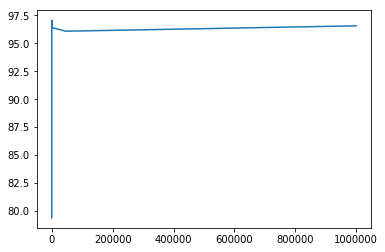

In [343]:
plt.plot(linear_rbf_table['c'], linear_rbf_table['result'])

In [481]:
m = {}
p_label = {}
p_acc = {}
p_val = {}
train_time = {}
test_time = {}

In [482]:
parastrs = {
    'linear' : '-t 0 -c 0.01',
    'polynomial coef=0' : '-t 1 -c 100 -g 0.0033333333333333335 -r 0 -d 2',
    'polynomial coef=1' : '-t 1 -c 1 -g 0.0033333333333333335 -r 1 -d 10',
    'RBF' : '-t 2 -c 100000 -g 0.02',
}
parastrs_precomputed = {
    'linear+RBF c=0.01' : '-t 4 -c 0.01',
    'linear+RBF c=100' : '-t 4 -c 100',
}

In [483]:
%%time

for kernel_type, opts in parastrs.items():
    if not (kernel_type in m):
        tic()
        m[kernel_type] = svmutil.svm_train(y_train, x_train, opts)
        train_time[kernel_type] = toc()
        tic()
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test, m[kernel_type])
        test_time[kernel_type] = toc()
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))
    
for kernel_type, opts in parastrs_precomputed.items():
    if not (kernel_type in m):
        tic()
        m[kernel_type] = svmutil.svm_train(y_train, x_train_precomputed, opts)
        train_time[kernel_type] = toc()
        tic()
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test_precomputed, m[kernel_type])
        test_time[kernel_type] = toc()
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))

Accuracy = 95.96% (2399/2500) (classification)
kernel type : linear , acc : (95.96000000000001, 0.1256, 0.938364320909239)

Accuracy = 97.72% (2443/2500) (classification)
kernel type : polynomial coef=0 , acc : (97.72, 0.0644, 0.9679859672752537)

Accuracy = 97.88% (2447/2500) (classification)
kernel type : polynomial coef=1 , acc : (97.88, 0.054, 0.973175045713461)

Accuracy = 98.48% (2462/2500) (classification)
kernel type : RBF , acc : (98.48, 0.0456, 0.9772791022489454)

Accuracy = 21.12% (528/2500) (classification)
kernel type : linear+RBF c=0.01 , acc : (21.12, 2.4232, 0.12948870230160855)

Accuracy = 19.12% (478/2500) (classification)
kernel type : linear+RBF c=100 , acc : (19.12, 2.888, 0.06279001721170396)

CPU times: user 1min 48s, sys: 27.9 ms, total: 1min 48s
Wall time: 1min 48s


In [460]:
_, tmp, _ = svmutil.svm_predict(y_train, x_train_precomputed, m['linear+RBF c=0.01'])
tmp[0]

Accuracy = 93.12% (4656/5000) (classification)


93.12

In [421]:
all_model = list(parastrs.keys()) # + list(parastrs_precomputed.keys())

In [382]:
[m[kk].get_nr_sv() for kk in all_model]

[1024, 813, 1021, 1022]

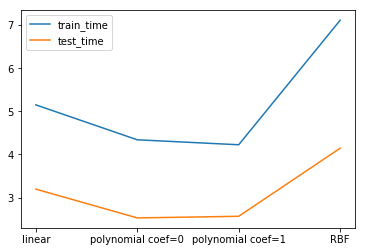

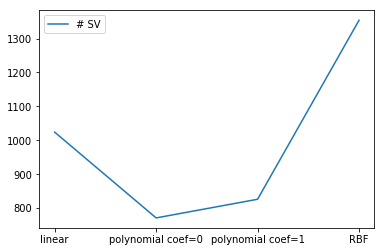

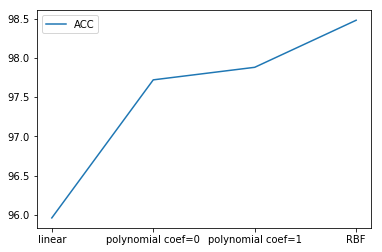

In [429]:
all_model = list(parastrs.keys())
plt.plot(all_model,[train_time[kk] for kk in all_model], label="train_time")
plt.plot(all_model,[test_time[kk] for kk in all_model], label="test_time")
plt.legend()
plt.show()

plt.plot(all_model,[m[kk].get_nr_sv() for kk in all_model], label="# SV")
plt.legend()
plt.show()

plt.plot(all_model,[p_acc[kk][0] for kk in all_model], label="ACC")
plt.legend()
plt.show()

In [389]:
len(set(m['linear'].get_sv_indices()) & set(m['RBF'].get_sv_indices()))

808

In [391]:
def repeatSV_indices(m1,m2):
    return set(m1.get_sv_indices()) & set(m2.get_sv_indices())

In [415]:
len(repeatSV_indices(m['linear'], m['RBF']) & repeatSV_indices(m['linear'], m['polynomial']))

650

### report

compare 4 diff kernel model

- accuracy
- number of support vector
- train time
- test time